In [3]:
import os
import time
import tensorflow as tf
import numpy as np
from skimage import io
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.transform import resize
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
%matplotlib inline

### 1) Data Access

In [4]:
#Read Training data and convert into Lab space
#To convert images to 256x256 use this command on the bash
#for i in *.jpg; do convert $i -scale 256x256 -gravity center -background white -extent 256x256 resized/f$i; don
#Read Training data
X = []
for filename in os.listdir('mixed/'):    
    X.append(img_to_array(load_img('mixed/'+filename)))
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X

In [5]:
#Convert into Lab space
for i in np.arange(len(Xtrain)):
    Xtrain[i] = rgb2lab(Xtrain[i])
    Xtrain[i] = (Xtrain[i] + [0, 128, 128]) / [100, 255, 255]

In [6]:
Xtrain.shape

(3486, 256, 256, 3)

In [7]:
#Separate X (Lightness) and Y(ab images)
Y_train = Xtrain[:,:,:,1:]
X_train = Xtrain[:,:,:,0]

In [8]:
X_train=X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))

In [10]:
#Read Testing data
X_test = []
for filename in os.listdir('test'):    
    X_test.append(img_to_array(load_img('test/'+filename))/255.)
X_test = np.array(X_test)

### 2) Model Building

In [11]:
#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=encoder_input, outputs=decoder_output)


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       295040    
__________

In [13]:
batch_size = 20
epochs = 30

In [14]:
#Train model      
#tensorboard = TensorBoard(log_dir="./output")
start_time = time.time()
model.compile(optimizer='adam', loss='mse')
history = model.fit(x=X_train,y=Y_train,batch_size=batch_size,epochs=epochs,
                    validation_split=0.10,shuffle=True)
print('Finished Training')
print("--- %s seconds ---" % (time.time() - start_time))

Train on 3137 samples, validate on 349 samples
Epoch 1/30
3137/3137 [==============================] - 88s 28ms/step - loss: 0.2344 - val_loss: 0.0411
Epoch 2/30
3137/3137 [==============================] - 76s 24ms/step - loss: 0.0560 - val_loss: 0.0460
Epoch 3/30
3137/3137 [==============================] - 76s 24ms/step - loss: 0.0528 - val_loss: 0.0424
Epoch 4/30
3137/3137 [==============================] - 77s 24ms/step - loss: 0.0526 - val_loss: 0.0375
Epoch 5/30
3137/3137 [==============================] - 77s 25ms/step - loss: 0.0525 - val_loss: 0.0377
Epoch 6/30
3137/3137 [==============================] - 76s 24ms/step - loss: 0.0508 - val_loss: 0.0380
Epoch 7/30
3137/3137 [==============================] - 77s 24ms/step - loss: 0.0522 - val_loss: 0.0433
Epoch 8/30
3137/3137 [==============================] - 77s 24ms/step - loss: 0.0517 - val_loss: 0.0482
Epoch 9/30
3137/3137 [==============================] - 78s 25ms/step - loss: 0.0508 - val_loss: 0.0365
Epoch 10/30
3137/

In [15]:
def plot_curves(history):
    loss = history.history['loss']
    val_loss=history.history['val_loss']
    epochs = range(1, len(loss)+1)
    with plt.style.context('fivethirtyeight'):
        plt.figure(figsize=(20,10))
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.legend(frameon=False)
        plt.show()
    

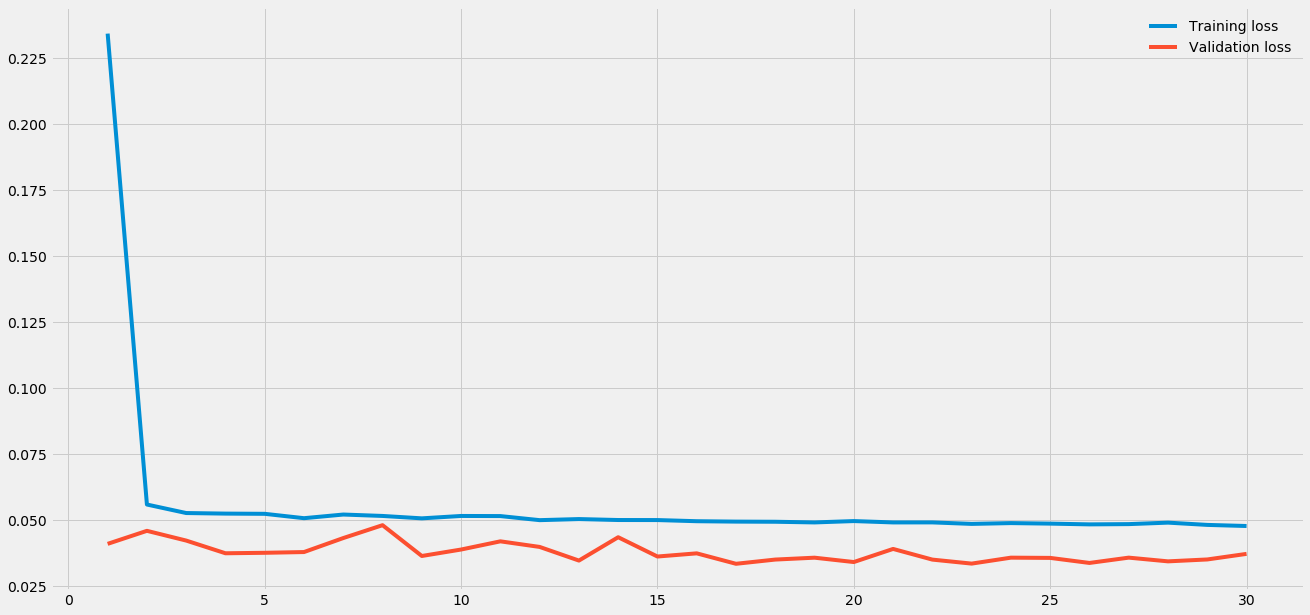

In [16]:
plot_curves(history)

In [17]:
def colour_image(image_data):
    input_img = rgb2lab(image_data)
    #input_img = rgb2gray(image_data)
    input_img = (input_img + [0, 128, 128]) / [100, 255, 255]
    input_img = input_img[:,:,0]
    input_img = input_img.reshape((1,256,256,1))
    imgout = model.predict(input_img)
    coloured = np.zeros((256,256,3))
    coloured[:,:,0] = input_img.reshape((256,256))
    coloured[:,:,1:] = imgout
    coloured = (coloured * [100, 255, 255]) - [0, 128, 128]
    rgb_image = lab2rgb(coloured)
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(rgb_image)
    plt.subplot(132)
    plt.imshow(image_data)
    plt.subplot(133)
    plt.imshow(rgb_image)
    

In [ ]:
for i in np.arange(20,30):
    image_number=i
    colour_image(X_test[image_number])